# Homework 1: 
## Riccardo Tancredi - riccardo.tancredi@studenti.unipd.it
---
## 1. Perform linear stability analysis of the deterministic logistic equation.

Starting from the logistic equation 
\begin{equation}
    \frac{dN}{dt} = \mu N \biggl(1-\frac{N}{k}\biggl)
\end{equation}
the linear stability analysis is performed by slightly perturbating the stable solution, which is given by imposing 
\begin{equation}
    \frac{dN}{dt} = 0 \implies N^\star = 0 \quad\vee\quad N^\star = k
\end{equation} 

Cosidering $\delta N = N_t - N^\star$ the small perturbation around the stable point $N^\star = 0$ (the other will be covered later), one gets:
\begin{equation}
    \begin{split}
        \dot{\delta N} &= J\vert_{N=N^\star}\hspace{1.5mm} \delta N \\
                       &= \frac{\partial f(N)}{\partial N}\vert_{N=N^\star}\hspace{1.5mm} \delta N \\
                       &= \left.\biggl(\mu (1-\frac{N}{k}\biggl)-\frac{\mu}{k}N\biggl)\right\vert_{N=N^\star}\hspace{1.5mm} \delta N \\
                       &= \left.\biggl(\mu - \frac{2\mu}{k}N\biggl)\right\vert_{N=N^\star} \hspace{1.5mm} \delta N
    \end{split}
\end{equation} 

For $N^\star = 0$ one gets 
\begin{equation}
    \dot{\delta N} = \mu \delta N, 
\end{equation}
while instead for $N^\star = k$ the linearization returns
\begin{equation}
    \dot{\delta N} = -\mu \delta N.
\end{equation}

We understand then that $N^\star = 0$ is an unstable point, while $N^\star = k$ is a stable one.

---

## 2. Perform the Quasi Stationary Approximation (QSA) of the consumer resource model with 1 species and 1 resource for the abiotic case. Check the analytical result with simulations.

For a consumer - resource model with 1 species and 1 resource, in the **abiotic** case, the equations differential equations describing our system are:
\begin{equation}
    \begin{cases}
        \frac{dN(t)}{dt} = \gamma N_t \biggl( cR - \frac{d}{\gamma}\biggl) \\
        \frac{dR(t)}{dt} = -cR N_t + \frac{R\mu_{max}}{R+k_s} = -cRN_t + \mu
    \end{cases}
\end{equation} 

The quasi stationary approximatimation is given by imposing:
\begin{equation}
    \frac{dR}{dt} \overset{!}{=} 0 \implies R^\star = \frac{\mu}{cN_t}
\end{equation}

Now $R=R^\star$ is fixed and we can replace the value of $R$ with $R^\star$ in the first differential equation:
\begin{equation}
    \begin{split}
        \frac{dN}{dt} &= N_t \biggl( \gamma cR^\star - d\biggl) \\
                      &= N_t \biggl( \gamma \cancel{c} \frac{\mu}{\cancel{c}N_t} - d\biggl) \\
                      & = \gamma\mu - d N_t
    \end{split}
\end{equation}

Integrating, one gets:
\begin{equation}
    N(t) = \frac{\gamma\mu}{d}-\frac{C}{d}e^{-td},
\end{equation}
where $C$ is a constant depending on the initial conditions. Imposing $N(t=0) = N_0$ then $C = \gamma\mu - dN_0$ and finally
\begin{equation}
    N(t) = \frac{\gamma\mu}{d}\biggl(1-e^{-td}\biggl) + N_0e^{-td},
\end{equation}


In [1]:
# Simulating the QSA:
import numpy as np
import matplotlib.pyplot as plt
from ODESolver import RungeKutta4

In [2]:
class QSA:
    def __init__(self, gamma, mu, c, d):
        self.gamma = gamma
        self.mu = mu
        self.c = c
        self.d = d

    def __call__(self, t, u):
        gamma, mu, c, d = self.gamma, self.mu, self.c, self.d
        N, R = u[0], u[1]
        dN = gamma*c*R*N - d*N
        dR = mu - c*N*R
        return dN, dR

In [3]:
gamma, mu, c, d = [5, 150, 0.01, 2]
QSA_simulation = QSA(gamma=gamma,
                    mu=mu,
                    c=c,
                    d=d)

evolution = RungeKutta4(QSA_simulation)
N_0 = 20
R_0 = 50
evolution.set_initial_condition([N_0, R_0])
t, u = evolution.solve(t_span=(0, 10), N=10000)

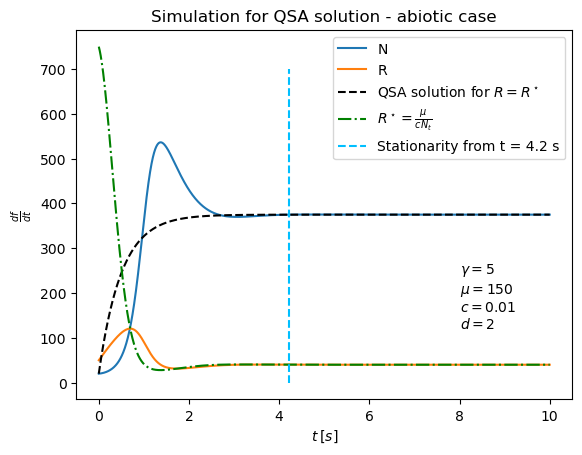

In [4]:
plt.plot(t, u[:, 0], label='N')
plt.plot(t, u[:, 1], label='R')

def QSA_solution(t, gamma, mu, d, N_0):
    return gamma*mu/d * (1-np.exp(-t*d)) + N_0*np.exp(-t*d)
y = np.array([QSA_solution(time, gamma, mu, d, N_0) for time in t])

plt.plot(t, y, linestyle='dashed', color='k', label=f'QSA solution for '+r'$R=R^\star$')
R_star = mu/(c*u[:, 0])

def stationarity_index(R_star): 
    ind = np.where(np.array([np.allclose(R_star[-1], R_star[i]) for i in range(len(R_star))]) == True)[0][0]
    return ind

plt.plot(t, R_star, ls='-.', color='g', label=r'$R^\star=\frac{\mu}{cN_t}$')
t_0 = t[stationarity_index(R_star)]
plt.vlines(t_0, 0, 700, color="deepskyblue", ls='--', label=f'Stationarity from t = {round(t_0, 1)} s')
plt.xlabel(r'$t\:[s]$')
plt.ylabel(r'$\frac{df}{dt}$')
plt.text(8, 120, r'$\gamma =$'+f'{gamma}\n'+r'$\mu =$'+f'{mu}\n'+r'$c =$'+f'{c}\n'+r'$d=$'+f'{d}')
plt.title('Simulation for QSA solution - abiotic case')
plt.savefig('Simulation_QSA_solution.png', dpi=300)
plt.legend()

plt.show()

---

## 3. Simulate the stochastic logistic model in your computer and check that the stationary distribution is a Gamma distribution.
Starting from the Fokker-Planck equation we can write the generalized Langevin equation as 
\begin{equation}
    \dot{x} = A(x) + \sqrt{B(x)}\xi_t
\end{equation}

<!-- Neglecting the $B(x)$ term we come back to the classical determistic equation. Supposing the noise is a random Gaussian variable with mean $\mu_G = 0$ and variance $\sigma_G^2=\sigma^2 dt$ we can sample $\xi_t$ from $\mathcal{N}(0, \sigma^2 dt) = \sigma dt \cdot\mathcal{N}(0,1)$. -->

The Stochastic Logistic Growth with Environmental noise is given by:
\begin{equation}
    \dot{x}_t = \frac{x_t}{\tau}\biggl(1-\frac{x_t}{K}\biggl) + \sqrt{\frac{\sigma}{\tau}}x_t\xi_t
\end{equation}
where $\xi_t$ is a Gaussian variable with the two properties: $\langle\xi_t\rangle = 0$ and $\langle\xi_t\xi_{t'}\rangle = \delta(t-t')$.

This is the **SDE** we want to simulate. 

The goal is to show that the stationary solution of the Fokker-Planck equation leads to a Gamma probability distribution $\Gamma(x; \alpha, \beta)$.

In [5]:
class SDE:
    def __init__(self, tau, K, sigma, dt):
        self.tau = tau
        self.K = K
        self.sigma = sigma
        self.dt = dt

    def __call__(self, t, x):
        tau, K, sigma, dt = self.tau, self.K, self.sigma, self.dt
        xi = np.random.normal(size=1)*np.sqrt(dt)
        dx = x/tau * (1-x/K) + np.sqrt(sigma/tau)*x*xi
        return dx

In [6]:
tau, K, sigma, dt = [10, 5, 50, 10/10000]
SDE_simulation = SDE(tau=tau,
                     K=K,
                     sigma=sigma,
                     dt=dt)

evolution = RungeKutta4(SDE_simulation)
x_0 = 2

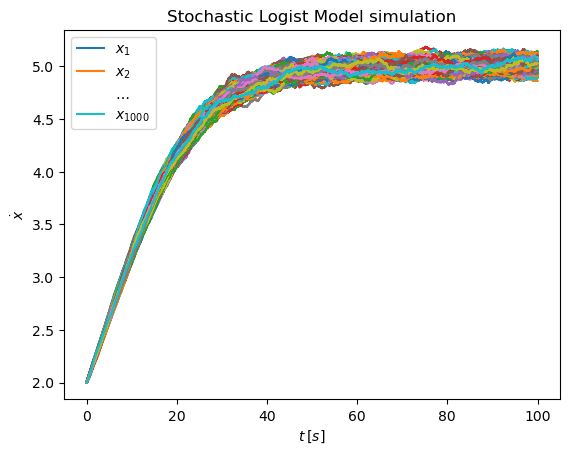

In [7]:
N = 1000
x_t = np.zeros(shape=N)
for i in range(N):
    evolution.set_initial_condition([x_0])
    t, u = evolution.solve(t_span=(0, 100), N=10000)
    x_t[i] = u[-1] # saving endpoint
    if i in [0, 1, N-1, N]:
        plt.plot(t, u, label=r'$x_{'+f'{i+1}'+r'}$')
    elif i == N/2:
        plt.plot([], [], ' ', label=r"$\dots$")
    else:
        plt.plot(t, u, label='')
    plt.xlabel(r'$t\:[s]$')
    plt.ylabel(r'$\dot{x}$')
plt.title('Stochastic Logist Model simulation')
plt.savefig('Stochastic_logistic_model.png', dpi=300)
plt.legend()
plt.show()

In [8]:
import scipy.stats as stats

# result's fit
gamma_distr = stats.gamma
param = gamma_distr.fit(x_t) # , floc=0
x = np.linspace(min(x_t), max(x_t), N)
pdf_fitted = gamma_distr.pdf(x, *param)

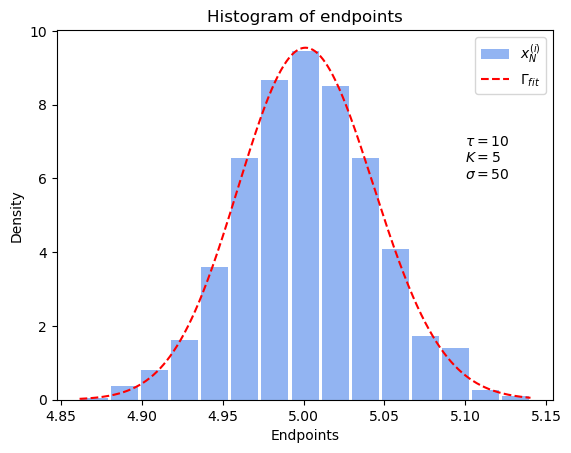

In [11]:
# To check that the stationary distribution is a Gamma distribution, we plot and fit the histogram of the endopoints of each trajectory
plt.hist(x_t, density=True, bins=15, label=r'$x_N^{(i)}$', color="cornflowerblue", alpha=0.7, rwidth=0.9)
plt.plot(x, pdf_fitted, color='r', ls='--', label=r'$\Gamma_{fit}$')
plt.text(5.10, 6, r'$\tau =$'+f'{tau}\n'+r'$K =$'+f'{K}\n'+r'$\sigma=$'+f'{sigma}')
plt.xlabel('Endpoints')
plt.ylabel('Density')
plt.title('Histogram of endpoints')
plt.legend()
plt.savefig('Hinstogram_of_endpoints_SLM.png', dpi=300)
plt.show()